In [1]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Flatten, concatenate, Lambda, BatchNormalization, Dropout
from tensorflow.keras.models import Model
import pandas as pd
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
import numpy as np
import tensorflow_hub as hub
import cv2
import csv
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.utils.vis_utils import plot_model
import tensorflow.keras.backend as K
from tensorflow.keras.applications.resnet50 import ResNet50


For consistency, we set a random state.

In [2]:
random_number = 42

In [3]:
tf.keras.utils.set_random_seed(random_number)

In [4]:
images_dir = './resized/'

We train the model on 20 thousand pairs, 40 thousand images total.

In [5]:
pairs = pd.read_csv("pairs20000.csv")

In [6]:
pairs['Path 1'] = images_dir + pairs['Path 1']
pairs['Path 2'] = images_dir + pairs['Path 2']

In [7]:
from sklearn.model_selection import train_test_split
train_df, unsplit_df = train_test_split(pairs, stratify=pairs["Label"], test_size=2000, shuffle = True, random_state = random_number)

In [8]:
val_df, test_df = train_test_split(unsplit_df, stratify=unsplit_df["Label"], test_size=1000, shuffle = True, random_state = random_number)

We perform a train-test-validation split. For a large dataset (40k pairs), validating only on 1 thousand images might not be enough to gauge the overall model performance, but we need to evaluate our model on 1 thousand images.

In [9]:
len(train_df)

38000

In [10]:
len(val_df)

1000

In [11]:
len(test_df)

1000

We use TensorFlow Hub to import a feature extraction model m-r50x1, which is a ResNet feature extraction model trained on the ImageNet-21k dataset (dataset with 14 milion images labeled with 21,843 classes). Output is the 2048 dimensional feature vector, not the classification category, therefore it is ideal for our purpose.

We chose this model because it had superior performance to the pre-trained Resnet provided with Keras, perhaps because this model is more generic.

In [12]:
import os
os.environ["TFHUB_CACHE_DIR"] = "C:/Users/karel"
hub_extractor = "https://tfhub.dev/google/bit/m-r50x1/1"

In [13]:
feature_extractor_layer = hub.KerasLayer(
    hub_extractor,
    input_shape=(224, 224, 3),
    trainable=False
)

This architecture proved to be the most successful, achieving over 81% validation accuracy on a smaller dataset (5k pairs).

We are using a "submodel" to ensure we can later use the comparison layer of the model for feature vectors.

In [14]:
input_layer_comparison_1 = Input(shape=(2048), name="left_input_compare")
input_layer_comparison_2 = Input(shape=(2048), name="right_input_compare")

subtracted = keras.layers.Subtract()([input_layer_comparison_1, input_layer_comparison_2])

x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=regularizers.L2(0.01))(subtracted)
x = BatchNormalization(epsilon=1e-06, momentum=0.9, weights=None)(x)
x = tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=regularizers.L2(0.01))(x)
x = tf.keras.layers.Dropout(0.3)(x)
classification_output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

In [15]:
model_compare = tf.keras.Model(inputs=[input_layer_comparison_1, input_layer_comparison_2], outputs = classification_output)

In [16]:
input_layer_1 = Input(shape=(224,224,3), name="left_input")
input_layer_2 = Input(shape=(224,224,3), name="right_input")

left = feature_extractor_layer(input_layer_1)
right = feature_extractor_layer(input_layer_2)

result = model_compare([left, right])


In [17]:
model = tf.keras.Model(inputs=[input_layer_1, input_layer_2], outputs = result)

In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_input (InputLayer)        [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 right_input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 keras_layer (KerasLayer)       (None, 2048)         23500352    ['left_input[0][0]',             
                                                                  'right_input[0][0]']      

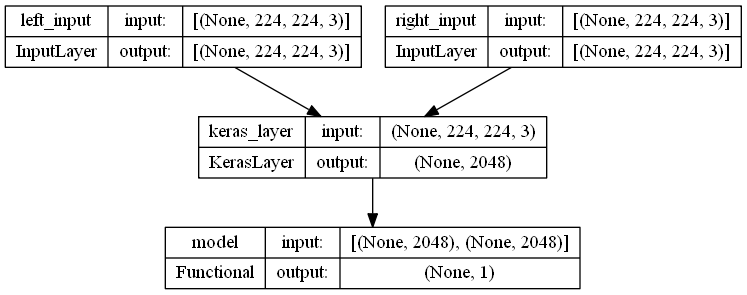

In [19]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [20]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics = [
        'accuracy'
    ]
)

Batch size of 64 sped up training and did not cause OOM errors, 128 did intermittently.

We will train the model for up to 15 epochs, but the model is stopped earlier due to early stopping callback.

In [21]:
batch_size = 64
num_epochs = 15

There was an attempt to cache preprocessed images, but loading always failed due to encoding issues. Solving this might improve training speed dramatically.

In [22]:
def get_image_array(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string)
    image = tf.keras.applications.resnet50.preprocess_input(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image

In [23]:
def dataset_generator_train():
    for pair, row in train_df.iterrows():
        image1 = get_image_array(row["Path 1"])
        image2 = get_image_array(row["Path 2"])
        yield (image1, image2), row["Label"]

In [24]:
def dataset_generator_val():
    for pair, row in val_df.iterrows():
        image1 = get_image_array(row["Path 1"])
        image2 = get_image_array(row["Path 2"])
        yield (image1, image2), row["Label"]

In [25]:
def dataset_generator_test():
    for pair, row in test_df.iterrows():
        image1 = get_image_array(row["Path 1"])
        image2 = get_image_array(row["Path 2"])
        yield (image1, image2), row["Label"]

In [26]:
dataset_train = tf.data.Dataset.from_generator(
    dataset_generator_train,
    output_signature = (
        (
            tf.TensorSpec(shape=(224,224,3), dtype=tf.float32),
            tf.TensorSpec(shape=(224,224,3), dtype=tf.float32),
        ),
        tf.TensorSpec(shape=(), dtype=tf.uint8)
    )
).batch(batch_size)

In [27]:
dataset_val = tf.data.Dataset.from_generator(
    dataset_generator_val,
    output_signature = (
        (
            tf.TensorSpec(shape=(224,224,3), dtype=tf.float32),
            tf.TensorSpec(shape=(224,224,3), dtype=tf.float32),
        ),
        tf.TensorSpec(shape=(), dtype=tf.uint8)
    )
).batch(batch_size)

In [28]:
dataset_test = tf.data.Dataset.from_generator(
    dataset_generator_test,
    output_signature = (
        (
            tf.TensorSpec(shape=(224,224,3), dtype=tf.float32),
            tf.TensorSpec(shape=(224,224,3), dtype=tf.float32),
        ),
        tf.TensorSpec(shape=(), dtype=tf.uint8)
    )
).batch(batch_size)

In [30]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True)

In [31]:
history = model.fit(
    dataset_train,
    epochs=num_epochs,
    validation_data = dataset_val,
    batch_size=batch_size,
    use_multiprocessing=True,
    callbacks=[callback]
)

Epoch 1/15
594/594 [==============================] - 979s 2s/step - loss: 1.2655 - accuracy: 0.7698 - val_loss: 0.5672 - val_accuracy: 0.7960
Epoch 2/15
594/594 [==============================] - 689s 1s/step - loss: 0.5603 - accuracy: 0.7867 - val_loss: 0.5205 - val_accuracy: 0.7950
Epoch 3/15
594/594 [==============================] - 463s 778ms/step - loss: 0.5500 - accuracy: 0.7866 - val_loss: 0.5180 - val_accuracy: 0.7990
Epoch 4/15
594/594 [==============================] - 459s 772ms/step - loss: 0.5539 - accuracy: 0.7876 - val_loss: 0.5165 - val_accuracy: 0.8070
Epoch 5/15
594/594 [==============================] - 459s 773ms/step - loss: 0.5533 - accuracy: 0.7904 - val_loss: 0.5229 - val_accuracy: 0.7990
Epoch 6/15
594/594 [==============================] - 462s 777ms/step - loss: 0.5522 - accuracy: 0.7945 - val_loss: 0.5156 - val_accuracy: 0.8120
Epoch 7/15
594/594 [==============================] - 462s 778ms/step - loss: 0.5508 - accuracy: 0.7953 - val_loss: 0.5168 - val_a

In [32]:
model_compare.save('models/v3_80pct_compare/')

INFO:tensorflow:Assets written to: models/v3_80pct_compare/assets


INFO:tensorflow:Assets written to: models/v3_80pct_compare/assets


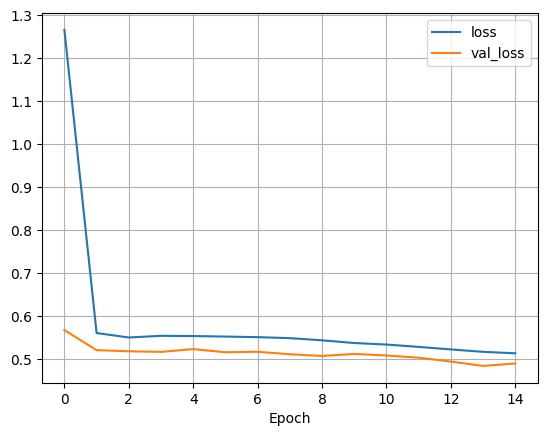

In [33]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

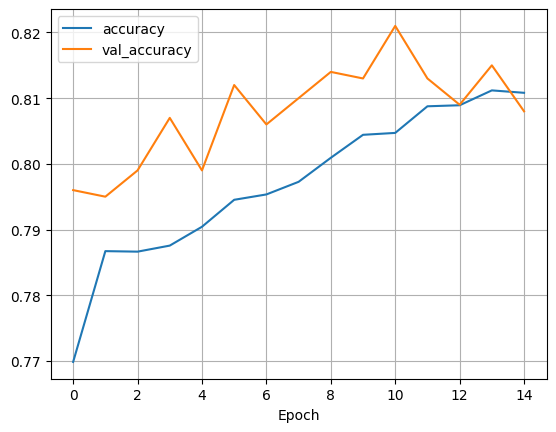

In [34]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')

plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

In [35]:
def create_confusion_matrix(predicted, real):
    import matplotlib.pyplot as plt
    from sklearn.metrics import ConfusionMatrixDisplay

    color = 'white'
    matrix = ConfusionMatrixDisplay.from_predictions(real, predicted, cmap=plt.cm.Blues, labels = [1, 0], display_labels = ["Same", "Different"])

    plt.show()

In [36]:
def show_image_pairs(pairs, title):
    
    plt.suptitle(title, fontweight ="bold")
    
    cols = 5
    rows = len(pairs) * 2 // cols
    
    for i in range(0, len(pairs) * 2):
        plt.subplot(rows, cols, i + 1)
        
        current_row = i // cols
        part = i % cols
        
        plt.axis('off')
        plt.imshow(
            pairs[part][current_row % 2]
        )
    
    plt.show()

In [37]:
def evaluation_report(generator, images_count = 5):
    import numpy as np

    label_val_predicted = []
    label_val_real = []
    fp_val_images = []
    fn_val_images = []

    for sample in generator():
        ((left_image, right_image), label_real) = sample

        left_image_expanded = np.expand_dims(left_image, axis=0) # network expects batches
        right_image_expanded = np.expand_dims(right_image, axis=0)
        # it is possible to use larger batch size

        label_predicted = model.predict(
            [left_image_expanded, right_image_expanded],
            batch_size = 1,
            verbose=0
        )[0][0]

        label_predicted = 1 if label_predicted > 0.5 else 0

        if label_predicted == 1 and label_real == 0 and len(fp_val_images) < images_count:
            # false positive
            fp_val_images.append((left_image, right_image))
        elif label_predicted == 0 and label_real == 1 and len(fn_val_images) < images_count:
            # false negative
            fn_val_images.append((left_image, right_image))

        label_val_predicted.append(label_predicted)
        label_val_real.append(label_real)
        
    create_confusion_matrix(label_val_predicted, label_val_real)
    show_image_pairs(fp_val_images, "False positive images")
    show_image_pairs(fn_val_images, "False negative images")

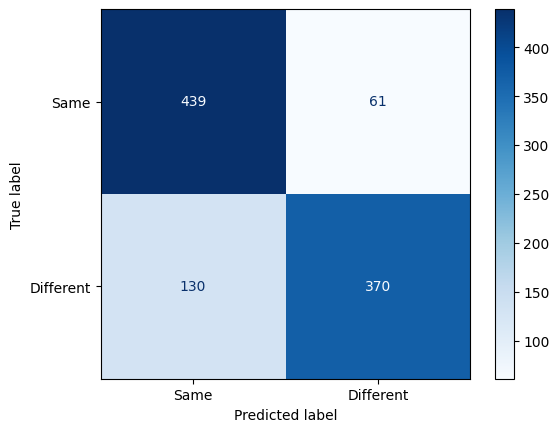

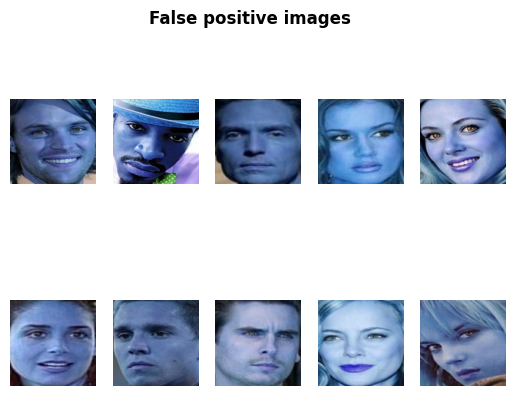

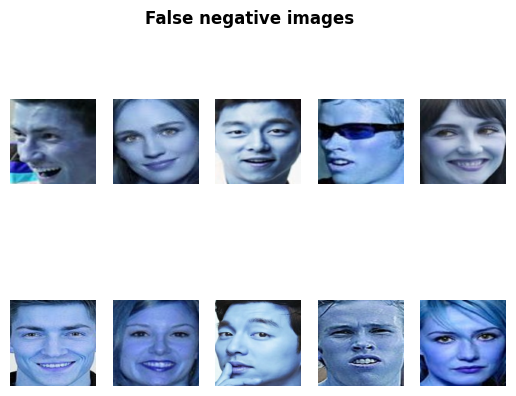

In [38]:
evaluation_report(dataset_generator_test)

On this testing dataset, we achieved accuracy of 0.806.

In [66]:
#model.save('models/v3_80pct/')


INFO:tensorflow:Assets written to: models/v3_80pct/assets


INFO:tensorflow:Assets written to: models/v3_80pct/assets
